PROJET INFO DIAM OPTIMISATION 

In [1]:
%pip install gurobipy

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------- ----------------------- 4.7/11.1 MB 23.7 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 28.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
import gurobipy as gp
from gurobipy import GRB

In [24]:
model = gp.Model('Usine')  #definition du modèle 

In [25]:


T0=4 # temps maximum de début
T=4 # temps maximum où les machines tournent
M=1 # nombre de machines
N=4 # nombre de taches
x, f = {}, {}


for m in range(M):
    for n in range(N):
        for t0 in range(T0):
            for t in range(T):
                x[n,m,t0,t] = model.addVar(name="n_%s,m_%s,t0_%s,t_%s"%(n,m,t0,t), vtype=GRB.BINARY) 
                f[n,m,t0,t] = model.addVar(name="n_%s,m_%s,t0_%s,t_%s"%(n,m,t0,t), vtype=GRB.BINARY) 
           

model.update()


In [26]:
#Dictionnaire perméttant le stockage des temps par tâche
temps = gp.multidict(
    {
        1 : 20,
        2 : 10,
        3 : 5,
        4 : 10,
    }
)

print(temps)


print("le temps est",temps[1][4])

[[1, 2, 3, 4], {1: 20, 2: 10, 3: 5, 4: 10}]
le temps est 10


In [27]:
#definition de la fonction coût 
def objective():
    
    maxi = 0 
    for i in range(M):
        #Somme = gp.quicksum( (temps[1][n])*x[n,m,t0,t] for t in range(T) for n in range(M))
        Somme = i + 1
        if gp.max_(maxi,Somme) > maxi:
            maxi = gp.max(maxi,Somme)
    return maxi
print(objective())
model.setObjective(objective(T,M), sense=GRB.MINIMIZE)
    


TypeError: '>' not supported between instances of 'GenExprMax' and 'int'

In [35]:
from gurobipy import *
from math import *
import random 
# === Données ===
#M = 13
#HORIZON = 50
#N = 5
#machines = range(M)
#commandes = range(N)  # N = nombre de commandes
#T = range(HORIZON)    # HORIZON : temps discret (ex. 0 à 100)

nb_commandes = 10
nb_machines = 13
nb_motifs = 4
horizon = 50  # durée totale du planning
max_setup_time = 3
commandes = list(range(nb_commandes))
machines = list(range(nb_machines))
motifs = list(range(nb_motifs))
T = list(range(horizon))
s = 3  # temps de réglage supposé constant sur le premier modèle
# à remplir avec l'input 
d = {c: random.randint(10, 40) for c in commandes}  # d[c] = date limite de livraison de la commande c
p = {c: random.randint(5, 15) for c in commandes}  # p[c] = temps total de production de la commande c
m_c = {c: random.choice(motifs) for c in commandes}  # m[c] = motif associé à la commande c
n = {m: random.randint(2, 5) for m in motifs}  # n[c] = nombre de tampons disponibles pour le motif
setup_time = {
    i: {
        j: 0 if i == j else random.randint(1, max_setup_time)
        for j in motifs
    } for i in motifs
}
# Poids dans la fonction objectif
POIDS_RETARD = 1000
POIDS_REGLAGE = 50
# === Modèle ===
model = Model("Gravure_Bouchons")

# Variables
x = model.addVars(commandes, machines, T, vtype=GRB.BINARY, name="x")
#1 si la machine m travaille à l’instant t sur la commande n

y = model.addVars(commandes, vtype=GRB.BINARY, name="y")  # livré à temps
start = model.addVars(commandes, vtype=GRB.INTEGER, name="start")
end = model.addVars(commandes, vtype=GRB.INTEGER, name="end")
change = model.addVars(machines, T, vtype=GRB.BINARY, name="change")
# Variable motif pour chaque machine et temps (optionnelle)
z = model.addVars(machines, T, vtype=GRB.INTEGER, name="z")

# === Contraintes ===

# 1. Chaque commande reçoit son temps de production requis
for c in commandes:
    model.addConstr(quicksum(x[c, m, t] for m in machines for t in T) >= p[c])

# 2. Chaque machine ne traite qu’une commande à la fois
for m in machines:
    for t in T:
        model.addConstr(quicksum(x[c, m, t] for c in commandes) <= 1)

# 3. Motif associé si la machine est occupée
for c in commandes:
    motif = m_c[c]
    for m in machines:
        for t in T:
            # Pour chaque motif possible, on interdit les autres si x=1
            for k in motifs:
                if k != motif:
                    model.addConstr(x[c, m, t] <= 1 - (z[m, t] == k))

#4 contraintes de changement 
for m in machines:
    for t in T[:-1]:
        model.addConstr(
            (z[m, t] != z[m, t + 1]) >> (change[m, t] == 1)
        )
        model.addConstr(
            (z[m, t] == z[m, t + 1]) >> (change[m, t] == 0)
        )
        
for m in machines:
    for t in T[:-1]:
        for i in motifs:
            for j in motifs:
                s_ij = setup_time[i][j]
                if s_ij > 0 and t + s_ij < max(T):
                    model.addConstrs(
                        (z[m, t] == i) & (z[m, t + 1] == j) >> 
                        (quicksum(x[c, m, t + k] for c in commandes) == 0)
                        for k in range(1, s_ij + 1)
                    )
                    
# 5. Calcul des débuts et fins
for c in commandes:
    model.addConstr(start[c] == min_([t for m in machines for t in T if x[c, m, t] == 1]))
    model.addConstr(end[c] == max_([t for m in machines for t in T if x[c, m, t] == 1]))

# 6. Livraison à l’heure
for c in commandes:
    model.addConstr(end[c] <= d[c] + (1 - y[c]) * BIG_M)

# === Fonction Objectif ===
# Minimiser le nombre de commandes en retard + temps total de production
model.setObjective(
    quicksum(1 - y[c] for c in commandes) * POIDS_RETARD,
    GRB.MINIMIZE
)

# === Résolution ===
model.optimize()

TypeError: unsupported operand type(s) for -: 'int' and 'TempConstr'

In [4]:
#Modèle Victor 
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum

model = gp.Model("timetable_discrete")

machines = 3
timeline = 48
ordres = [
    {'numéro': 1, 'duration': 2, 'due date': 10}, {'numéro': 2, 'duration': 2, 'due date': 10},
    {'numéro': 3, 'duration': 1, 'due date': 10}, {'numéro': 4, 'duration': 2, 'due date': 10},
    {'numéro': 5, 'duration': 3, 'due date': 15}, {'numéro': 6, 'duration': 4, 'due date': 15},
    {'numéro': 7, 'duration': 2, 'due date': 20}, {'numéro': 8, 'duration': 4, 'due date': 20},
    {'numéro': 9, 'duration': 2, 'due date': 30}, {'numéro': 10, 'duration': 2, 'due date': 30},
    {'numéro': 11, 'duration': 2, 'due date': 30}, {'numéro': 12, 'duration': 2, 'due date': 30},
    {'numéro': 13, 'duration': 10, 'due date': 40}, {'numéro': 14, 'duration': 2, 'due date': 45},
    {'numéro': 15, 'duration': 8, 'due date': 40}, {'numéro': 16, 'duration': 5, 'due date': 40},
    {'numéro': 17, 'duration': 2, 'due date': 35}, {'numéro': 18, 'duration': 12, 'due date': 30},
    {'numéro': 19, 'duration': 2, 'due date': 30}, {'numéro': 20, 'duration': 3, 'due date': 30}
]
#CHANGEMENT POUR AJOUTER LA CONTRAINTE DE CHANGEMENT 
T_change = 1
change = model.addVars(machines, timeline, vtype=GRB.BINARY, name="change")
#//// CHANGEMENT POUR AJOUTER LA CONTRAINTE DE CHANGEMENT 

x = {}
for i, ordre in enumerate(ordres):
    for m in range(machines):
        for t in range(timeline):  # tmax = timeline - durée + 1
            x[i, t, m] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_t{t}_m{m}")

model.setObjective(0, GRB.MINIMIZE)

for i, ordre in enumerate(ordres):
    model.addConstr(
        gp.quicksum(x[i, t, m] for m in range(machines)
                    for t in range(ordre['due date'])) == ordre['duration'],name=f"assign_{i}")

for m in range(machines):
    for t in range(timeline):
        model.addConstr(
            gp.quicksum(
                x[i, t, m]
                for i, ordre in enumerate(ordres) )<= 1,
            name=f"machine_{m}time{t}")

#//// CHANGEMENT POUR AJOUTER LA CONTRAINTE DE CHANGEMENT 
for i, ordre in enumerate(ordres):
    for m in range(machines):
        for t in range(timeline):
            model.addConstr(
                (x[i,m,t] != x[i, m, t + 1]) >> (change[m, t] == 1)  #les >> c'est pour faire du si ... alors 
            )
            model.addConstr(
                (x[i,m, t] == x[i,m, t + 1]) >> (change[m, t] == 0)
            )



for m in machines:
    for t in range(timeline):
            if (change[m,t]==1) and t + T_change < max(T):
                model.addConstrs(
                    (quicksum(x[i, m, t + k] for i, ordre in enumerate(ordres) ) == 0)
                    for k in range(1, T_change + 1)
                )
                    
#////

model.optimize()

if model.status == GRB.OPTIMAL:
    for (i, t, m), var in x.items():
        if var.X > 0.5:
            print(f"Ordre {ordres[i]['numéro']} démarre à t={t} sur machine {m} (durée: {ordres[i]['duration']})")
else:
    print("Pas de solution optimale trouvée.")

GurobiError: Inequality constraints not supported

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 302 rows, 3024 columns and 7338 nonzeros
Model fingerprint: 0x03357cef
Model has 141 quadratic constraints
Variable types: 0 continuous, 3024 integer (3024 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 138 rows and 6 columns
Presolve time: 0.06s
Presolved: 53885 rows, 56598 columns, 219036 nonzeros
Variable types: 0 continuous, 56598 integer (56598 binary)
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.18 seconds (0.09 work units)
Thread count was 12 (of 12 available processors)

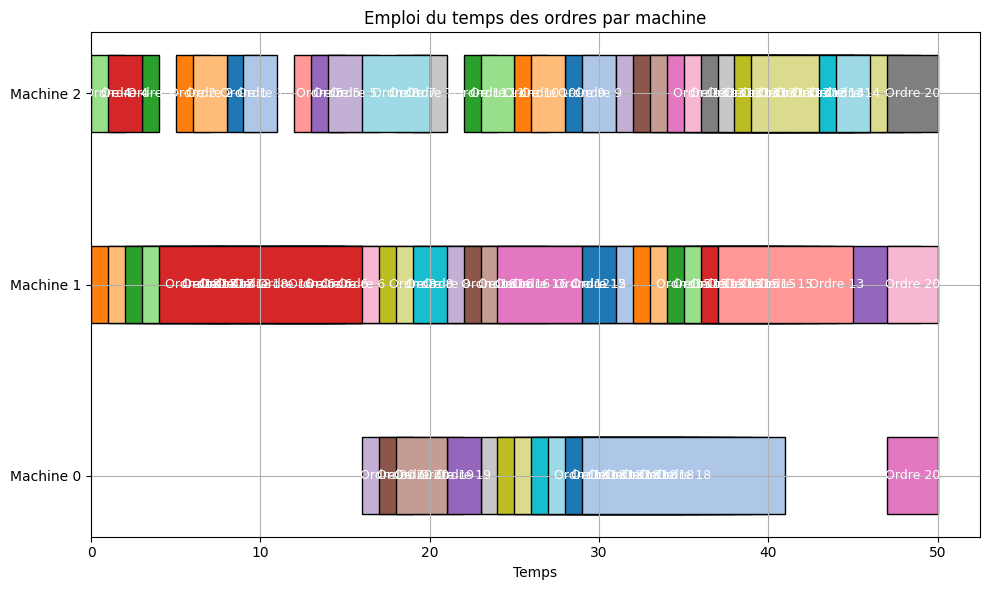

In [13]:
from gurobipy import quicksum
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

model = gp.Model("timetable_discrete")

machines = 3
timeline = 48
ordres = [
    {'numéro': 1, 'duration': 2, 'due date': 10}, {'numéro': 2, 'duration': 2, 'due date': 10},
    {'numéro': 3, 'duration': 1, 'due date': 10}, {'numéro': 4, 'duration': 2, 'due date': 10},
    {'numéro': 5, 'duration': 3, 'due date': 15}, {'numéro': 6, 'duration': 4, 'due date': 15},
    {'numéro': 7, 'duration': 2, 'due date': 20}, {'numéro': 8, 'duration': 4, 'due date': 20},
    {'numéro': 9, 'duration': 2, 'due date': 30}, {'numéro': 10, 'duration': 2, 'due date': 30},
    {'numéro': 11, 'duration': 2, 'due date': 30}, {'numéro': 12, 'duration': 2, 'due date': 30},
    {'numéro': 13, 'duration': 10, 'due date': 40}, {'numéro': 14, 'duration': 2, 'due date': 45},
    {'numéro': 15, 'duration': 8, 'due date': 40}, {'numéro': 16, 'duration': 5, 'due date': 40},
    {'numéro': 17, 'duration': 2, 'due date': 35}, {'numéro': 18, 'duration': 12, 'due date': 30},
    {'numéro': 19, 'duration': 2, 'due date': 30}, {'numéro': 20, 'duration': 3, 'due date': 30}
]
#CHANGEMENT POUR AJOUTER LA CONTRAINTE DE CHANGEMENT 
T_change = 1
change = model.addVars(machines, timeline, vtype=GRB.BINARY, name="change")
#//// CHANGEMENT POUR AJOUTER LA CONTRAINTE DE CHANGEMENT 

x = {}
for i, ordre in enumerate(ordres):
    for m in range(machines):
        for t in range(timeline):  # tmax = timeline - durée + 1
            x[i, t, m] = model.addVar(vtype=GRB.BINARY, name=f"x_{i}_t{t}_m{m}")

model.setObjective(0, GRB.MINIMIZE)

for i, ordre in enumerate(ordres):
    model.addConstr(
        gp.quicksum(x[i, t, m] for m in range(machines)
                    for t in range(ordre['due date'])) == ordre['duration'],name=f"assign_{i}")

for m in range(machines):
    for t in range(timeline):
        model.addConstr(
            gp.quicksum(
                x[i, t, m]
                for i, ordre in enumerate(ordres) )<= 1,
            name=f"machine_{m}time{t}")
        
#//// CHANGEMENT POUR AJOUTER LA CONTRAINTE DE CHANGEMENT 
# Détecter un changement de production sur la machine m entre t et t+1
for m in range(machines):
    for t in range(timeline - 1):
        model.addConstr(
            change[m, t] >= gp.quicksum(
                x[i, t, m] * x[j, t + 1, m]
                for i in range(len(ordres)) for j in range(len(ordres)) if i != j
            ),
            name=f"change_detect_m{m}_t{t}"
        )
# Imposer une pause après un changement
for m in range(machines):
    for t in range(timeline - T_change - 1):
        for k in range(1, T_change + 1):
            model.addConstr(
                gp.quicksum(x[i, t + k, m] for i in range(len(ordres))) <= (1 - change[m, t]),
                name=f"pause_after_change_m{m}_t{t}_k{k}"
            )
            
#//// CHANGEMENT POUR AJOUTER LA CONTRAINTE DE CHANGEMENT 

model.optimize()

# x = {(i, t, m): var}  avec var.X > 0.5 si l’ordre i commence à t sur machine m
# ordres = {i: {'numéro': id, 'duration': d}}

schedule = []

if model.status == GRB.OPTIMAL:
    for (i, t, m), var in x.items():
        if var.X > 0.5:
            duration = ordres[i]['duration']
            order_id = ordres[i]['numéro']
            schedule.append({
                'Machine': m,
                'Start': t,
                'Duration': duration,
                'Order': f"Ordre {order_id}"
            })
else:
    print("Pas de solution optimale trouvée.")
        

# Regrouper par machine
machines = sorted(set(task['Machine'] for task in schedule))
machine_to_y = {m: idx for idx, m in enumerate(machines)}

# Tracer
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.tab20.colors  # palette de couleurs

for idx, task in enumerate(schedule):
    y = machine_to_y[task['Machine']]
    ax.barh(y, task['Duration'], left=task['Start'], height=0.4,
            color=colors[idx % len(colors)], edgecolor='black')
    ax.text(task['Start'] + task['Duration']/2, y, task['Order'],
            va='center', ha='center', fontsize=9, color='white')

# Axe y avec noms de machines
ax.set_yticks(range(len(machines)))
ax.set_yticklabels([f"Machine {m}" for m in machines])
ax.set_xlabel("Temps")
ax.set_title("Emploi du temps des ordres par machine")
ax.grid(True)

plt.tight_layout()
plt.show()